# Air Quality Prediction and Smart Advisory System

## Project Overview
This project focuses on predicting air quality levels (AQI) across multiple cities using historical pollutant data. The ultimate goal is not only to accurately classify AQI into standard categories (Good, Moderate, Poor, etc.) but also to provide actionable insights for public health and environmental monitoring.

## Dataset Description
The dataset contains **29,531 records** with **16 features**, including measurements of pollutants such as PM2.5, PM10, NO₂, SO₂, CO, O₃, Benzene, Toluene, Xylene, and additional contextual information like City and Date. The target variable is `AQI_Bucket`, which categorizes air quality into severity levels.

## Project Workflow

### 1. Data Preprocessing
- **Cleaning:** Handle missing values, duplicates, and outliers in pollutant measurements.
- **Transformation:** Extract temporal features (month, day, season), encode categorical variables, and scale numerical features.
- **Feature Engineering:** Create pollutant ratios, lag features, and rolling averages to capture temporal and chemical relationships.

### 2. Exploratory Data Analysis (EDA)
- **Univariate Analysis:** Examine distributions of pollutants and AQI_Bucket.
- **Bivariate Analysis:** Correlations between pollutants and AQI; scatterplots to visualize pollutant impact.
- **Temporal & Spatial Analysis:** City-level time series plots and geospatial heatmaps to identify patterns.

### 3. Model Selection
- Primary models: **Random Forest, XGBoost, LightGBM** for classification.
- Optional temporal enhancement: **LSTM Neural Network** to capture sequential trends.
- Selection is based on model robustness, interpretability, and regulatory requirements.

### 4. Model Development
- **Data Splitting:** Train, validation, and test sets with temporal integrity.
- **Training & Tuning:** Hyperparameter optimization using grid search or Bayesian methods.
- **Evaluation:** Accuracy, F1-score, and confusion matrix, with special attention to high-risk AQI categories.

### 5. Innovation
- **Real-Time AQI Forecasting:** Predict AQI for next 24–72 hours.
- **Smart Advisory System:** Provide city-specific health alerts and recommendations for vulnerable populations.
- **Pollution Spike Detection:** Identify unusual pollutant patterns and notify relevant authorities.

### 6. Regulatory Compliance
- Ensure adherence to **WHO and national air quality guidelines**.
- Maintain full audit trails for preprocessing, modeling, and decision-making.
- Evaluate fairness across cities and socio-economic regions.

### 7. Explanation & Visualization
- **SHAP Values:** Explain the contribution of each pollutant to AQI predictions.
- **Interactive Dashboards:** Visualize pollutant trends, AQI predictions, and health advisories.
- **Stakeholder Reporting:** Provide plain-language summaries and actionable insights.

## Objective
By following this workflow, the project aims to produce a **robust, explainable, and actionable air quality prediction system** that serves as an industry benchmark for both modeling and real-world impact.



In [1]:
# Environment Setup

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# --- Preprocessing & Modeling ---
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# --- Models ---
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

# --- Explainability ---
import shap

# --- Warnings & Display Settings ---
import warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

print("Environment setup complete. All libraries imported successfully!")


Environment setup complete. All libraries imported successfully!


In [2]:
# Load and Inspect Dataset

# Load the dataset
df = pd.read_csv("city_day.csv")

# Display the first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

# Basic info about the dataset
print("\nDataset Information:")
df.info()

# Summary statistics for numerical features
print("\nSummary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values per Column:")
missing_values = df.isnull().sum()
display(missing_values[missing_values > 0])


First 5 rows of the dataset:


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB

Summary Statistics:


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000



Missing Values per Column:


PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

In [3]:
# Data Preprocessing

# --- Handle Missing Values ---

# Drop rows where target (AQI and AQI_Bucket) is missing
df = df.dropna(subset=['AQI', 'AQI_Bucket'])

# Fill missing pollutant values with median per city
pollutant_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
for col in pollutant_cols:
    df[col] = df.groupby('City')[col].transform(lambda x: x.fillna(x.median()))

# --- Feature Engineering ---

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Pollutant ratios (example: PM2.5/PM10)
df['PM_Ratio'] = df['PM2.5'] / (df['PM10'] + 1e-5)  # avoid division by zero

# --- Outlier Treatment ---

# Cap extreme values using 99th percentile
for col in pollutant_cols:
    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)
    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

print("Preprocessing complete. Dataset ready for EDA and modeling.")
display(df.head())


Preprocessing complete. Dataset ready for EDA and modeling.


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Year,Month,Day,DayOfWeek,PM_Ratio
28,Ahmedabad,2015-01-29,83.13,107.67,6.93,28.71,33.72,NaN,6.9300,49.52,59.7600,0.02,0.00,3.1400,209.0,Poor,2015,1,29,3,0.772081
29,Ahmedabad,2015-01-30,79.84,107.67,13.85,28.68,41.08,NaN,13.8500,48.49,97.0700,0.04,0.00,4.8100,328.0,Very Poor,2015,1,30,4,0.741525
30,Ahmedabad,2015-01-31,94.52,107.67,24.39,32.66,52.61,NaN,24.3900,67.39,105.0952,0.24,0.01,7.6700,514.0,Severe,2015,1,31,5,0.877867
31,Ahmedabad,2015-02-01,135.99,107.67,43.48,42.08,84.57,NaN,34.9512,75.23,102.7000,0.40,0.04,25.8700,782.0,Severe,2015,2,1,6,1.263026
32,Ahmedabad,2015-02-02,178.33,107.67,54.56,35.31,72.80,NaN,34.9512,55.04,105.0952,0.46,0.06,25.9764,914.0,Severe,2015,2,2,0,1.656264


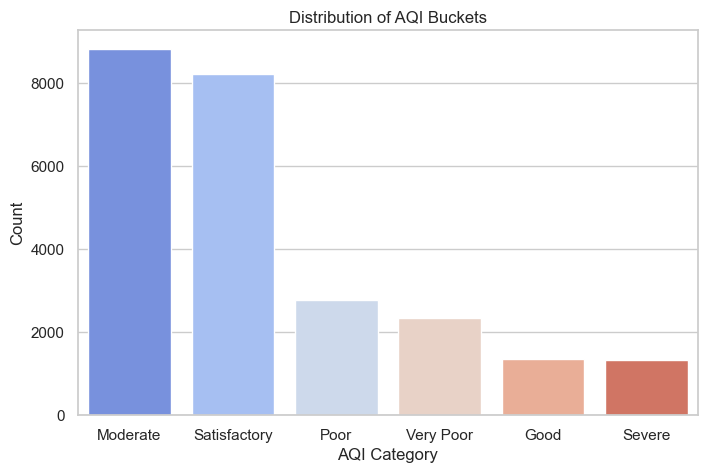

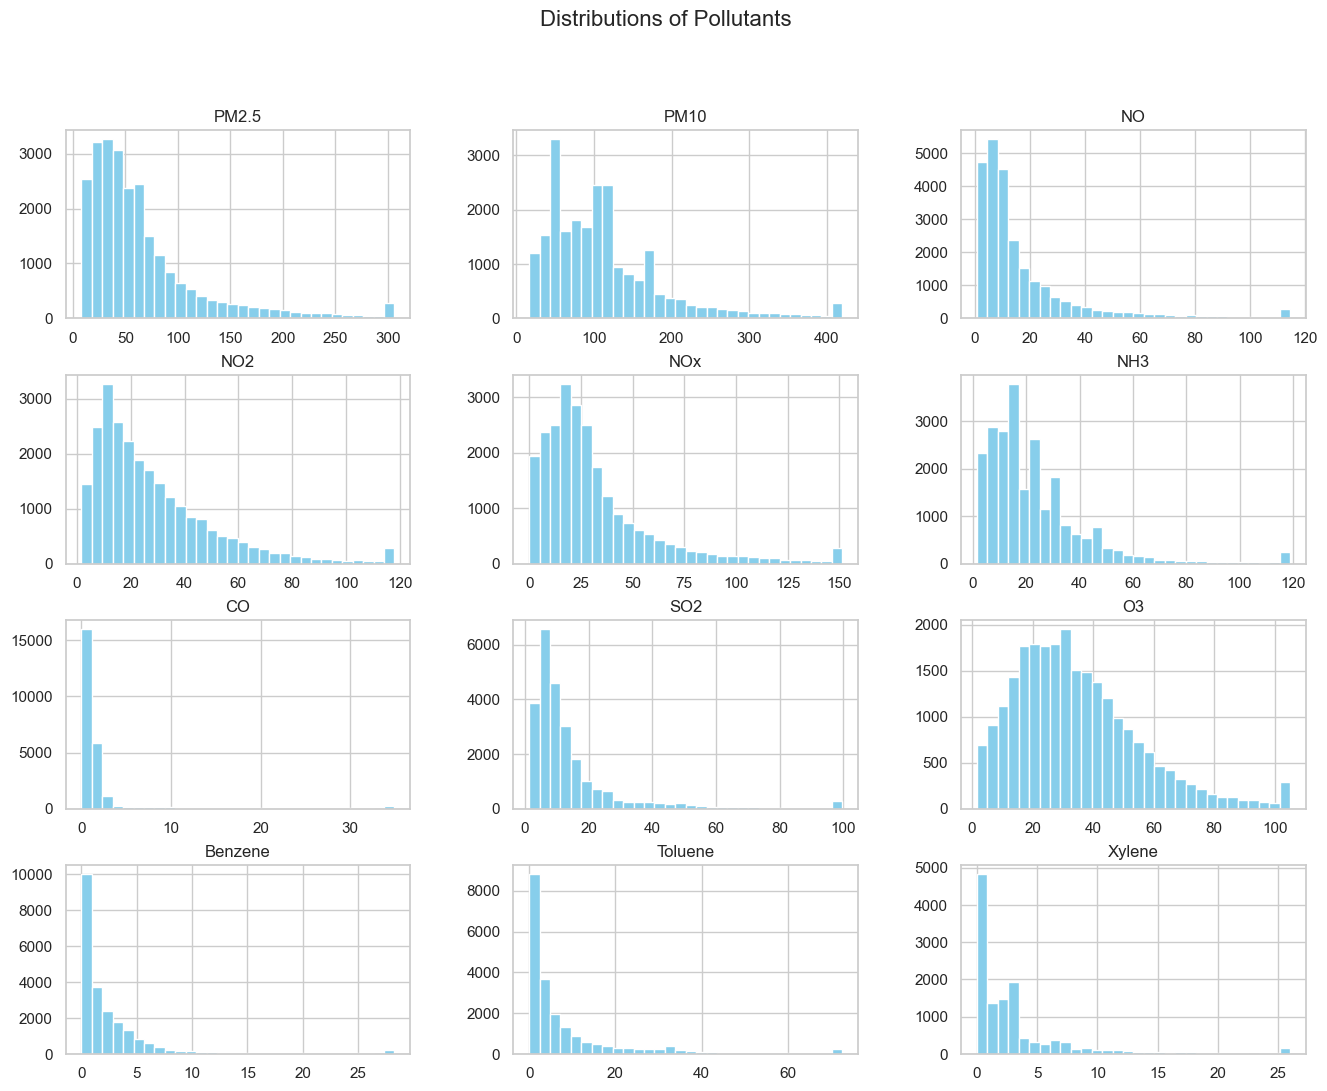

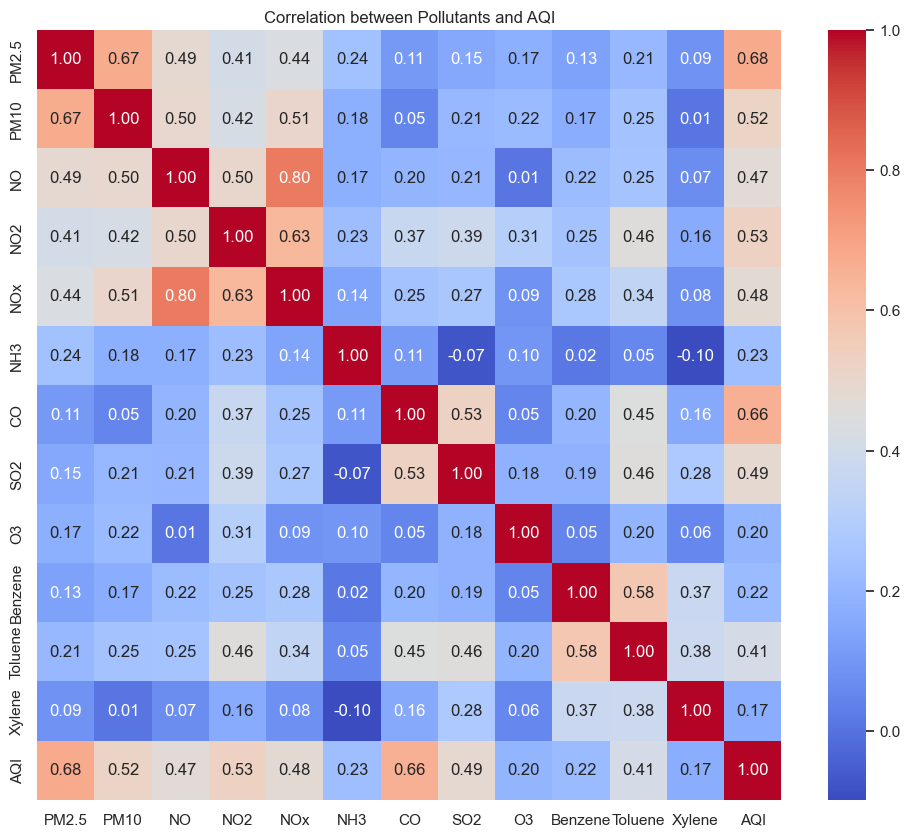

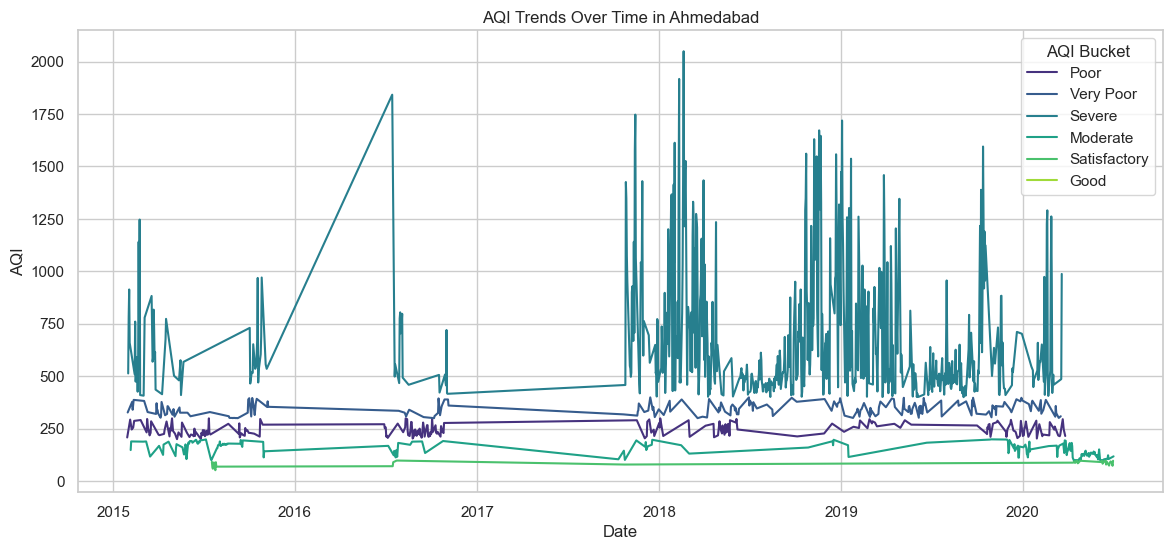

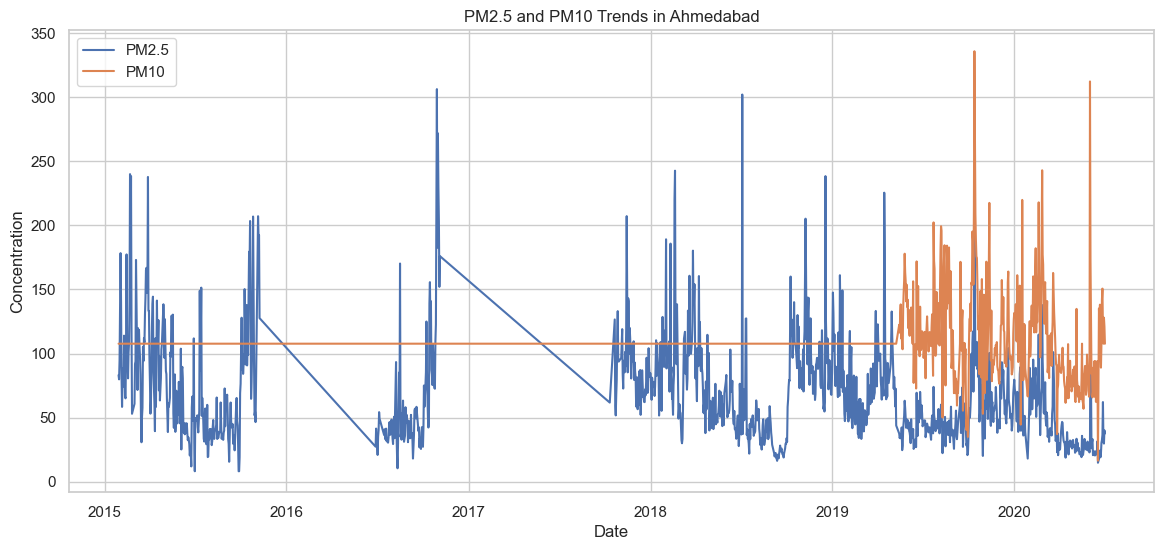

In [4]:
# Exploratory Data Analysis (EDA)

# --- AQI Bucket Distribution ---
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='AQI_Bucket', order=df['AQI_Bucket'].value_counts().index, palette='coolwarm')
plt.title("Distribution of AQI Buckets")
plt.xlabel("AQI Category")
plt.ylabel("Count")
plt.show()

# --- Pollutant Distributions ---
pollutant_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
df[pollutant_cols].hist(bins=30, figsize=(16,12), color='skyblue')
plt.suptitle("Distributions of Pollutants", fontsize=16)
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(12,10))
sns.heatmap(df[pollutant_cols + ['AQI']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between Pollutants and AQI")
plt.show()

# --- Temporal Analysis: AQI over time for a sample city ---
sample_city = df['City'].unique()[0]  # Ahmedabad as example
city_df = df[df['City'] == sample_city]

plt.figure(figsize=(14,6))
sns.lineplot(data=city_df, x='Date', y='AQI', hue='AQI_Bucket', palette='viridis')
plt.title(f"AQI Trends Over Time in {sample_city}")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend(title='AQI Bucket')
plt.show()

# --- Pollutant Trends Over Time ---
plt.figure(figsize=(14,6))
sns.lineplot(data=city_df, x='Date', y='PM2.5', label='PM2.5')
sns.lineplot(data=city_df, x='Date', y='PM10', label='PM10')
plt.title(f"PM2.5 and PM10 Trends in {sample_city}")
plt.xlabel("Date")
plt.ylabel("Concentration")
plt.legend()
plt.show()


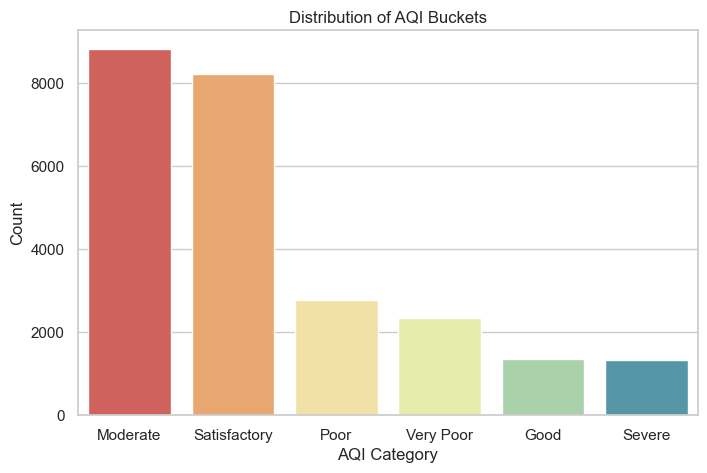

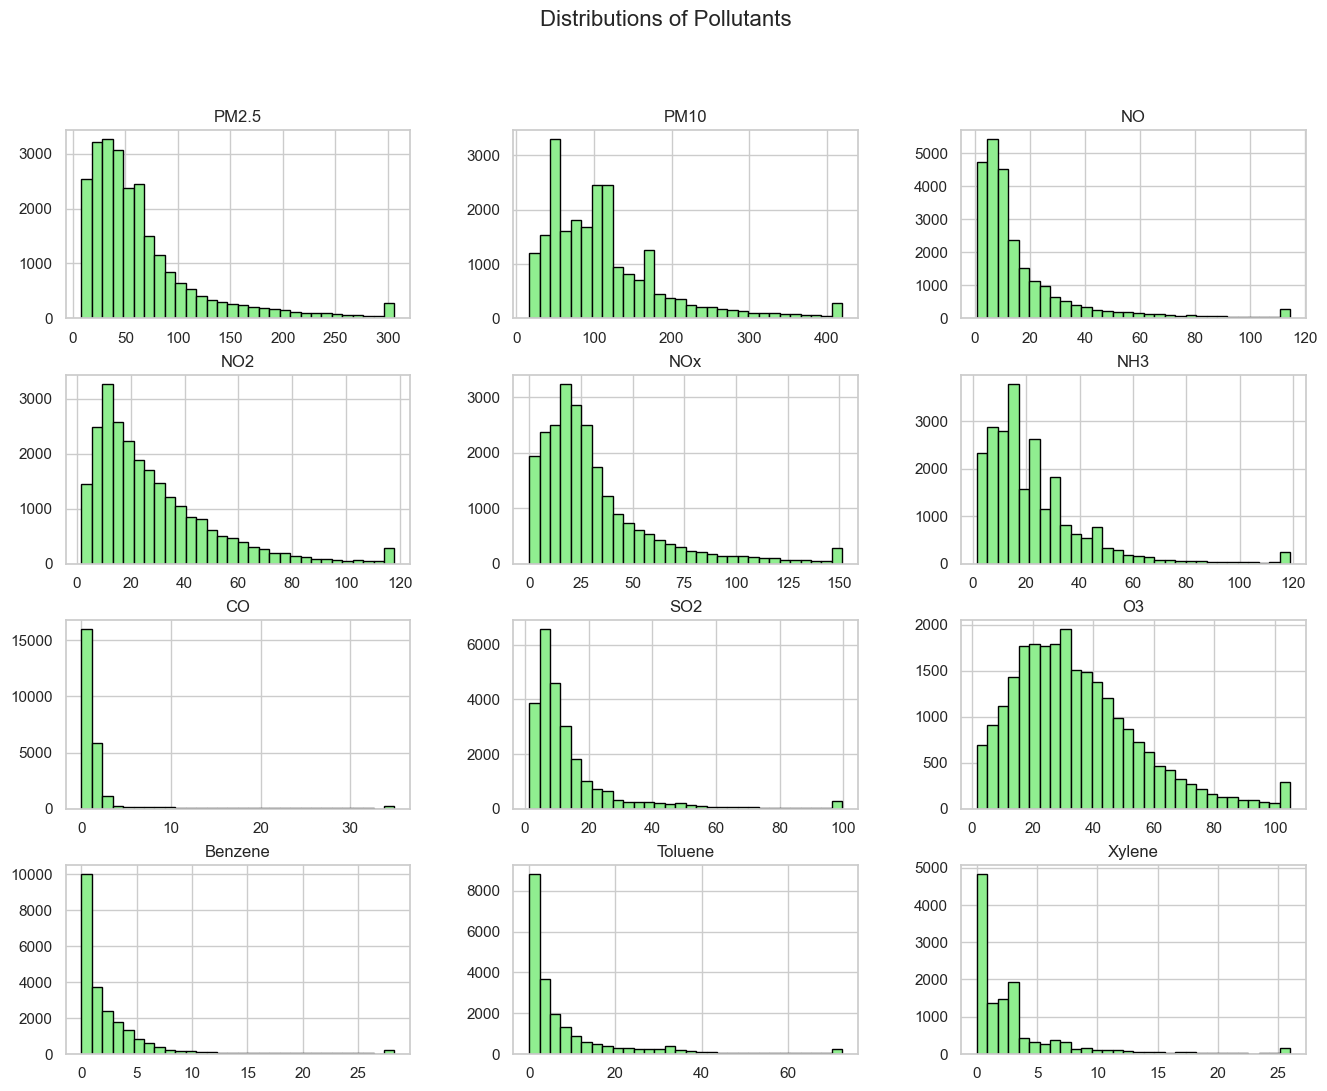

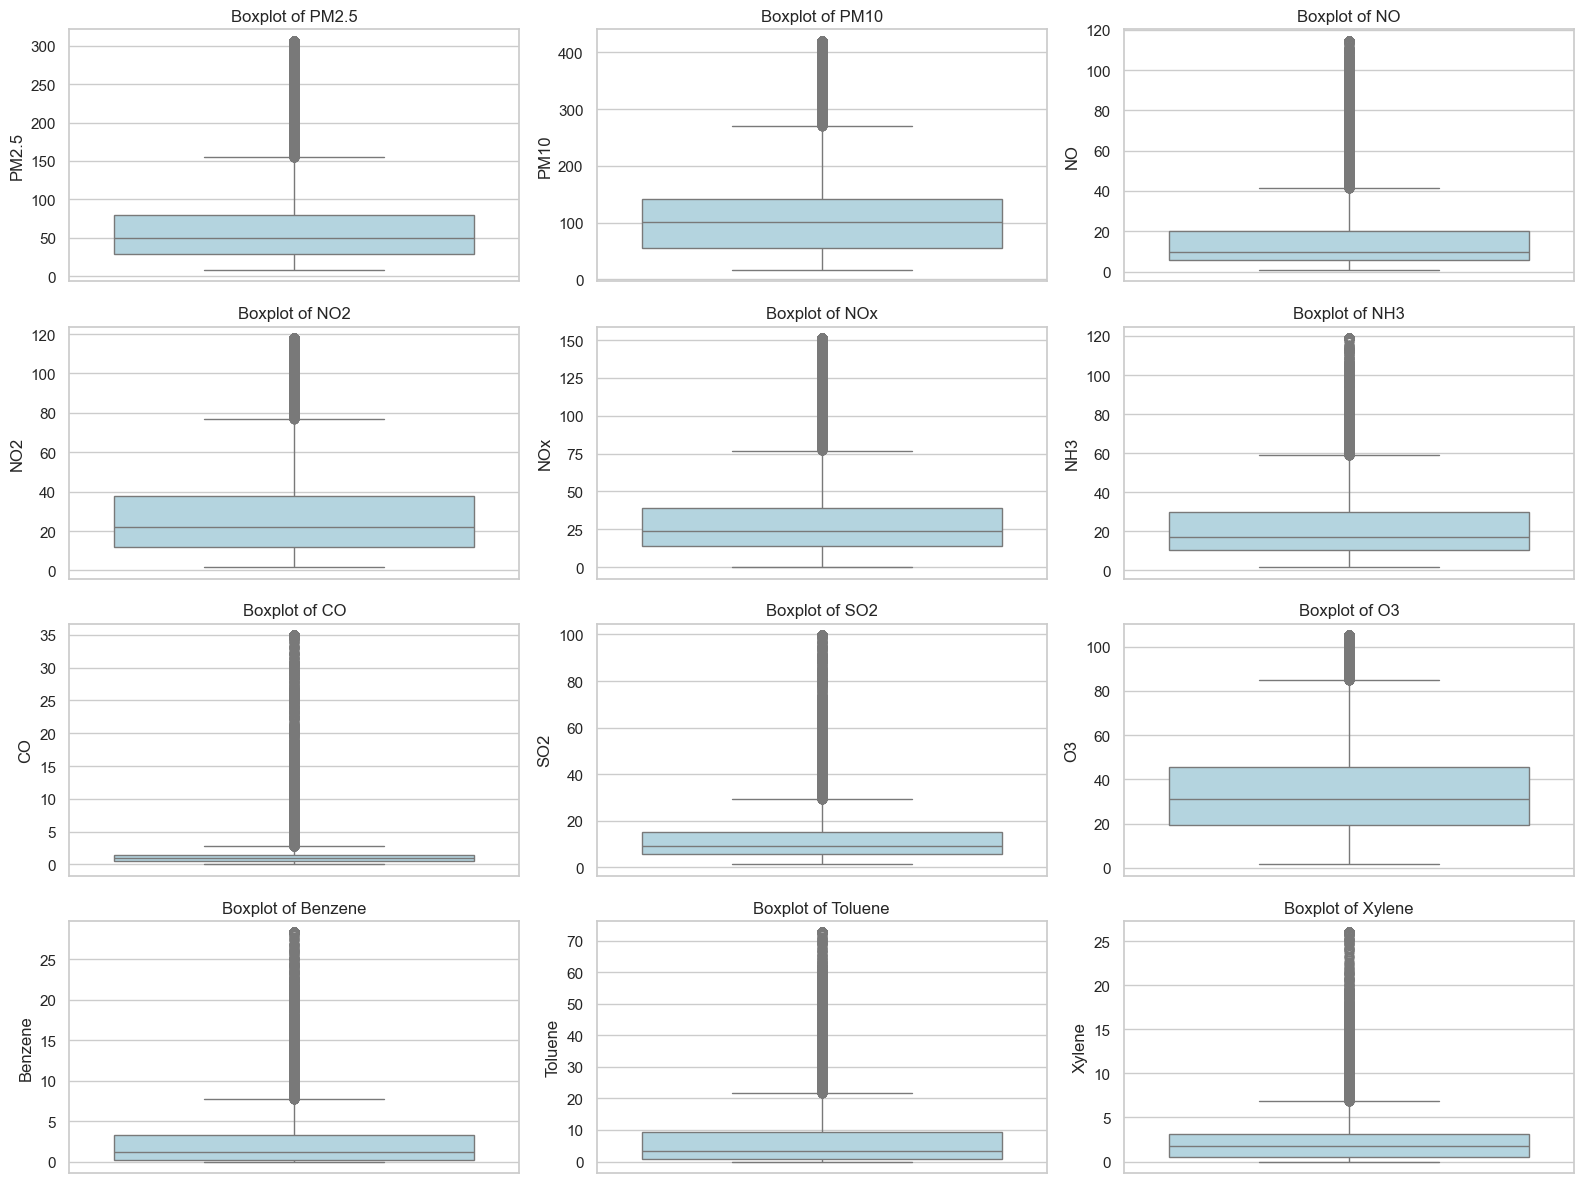

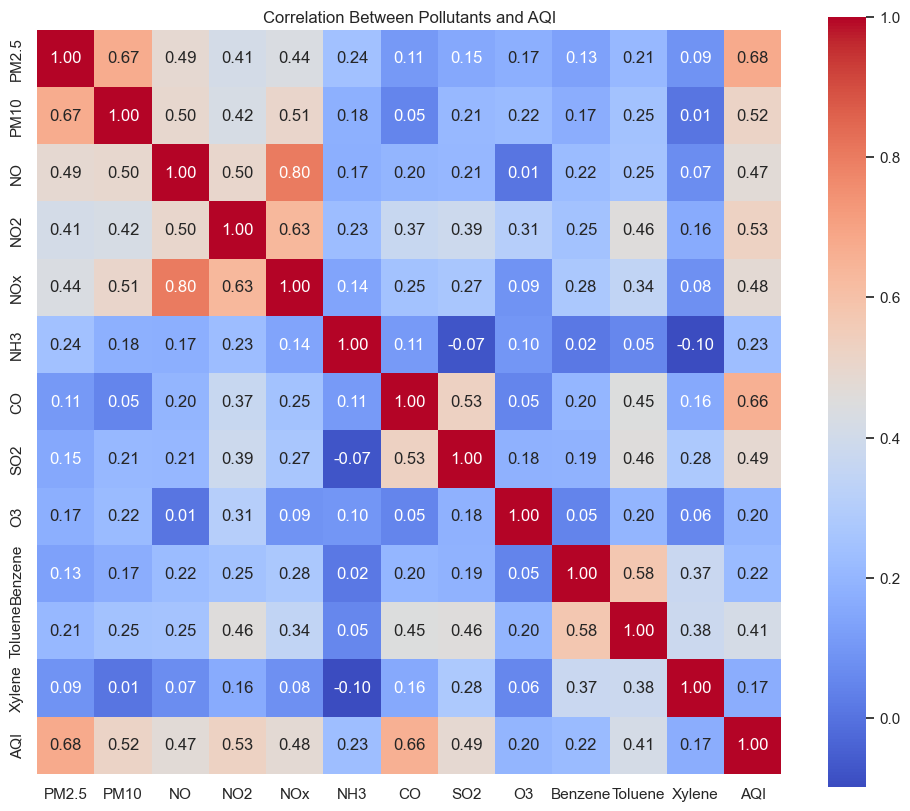

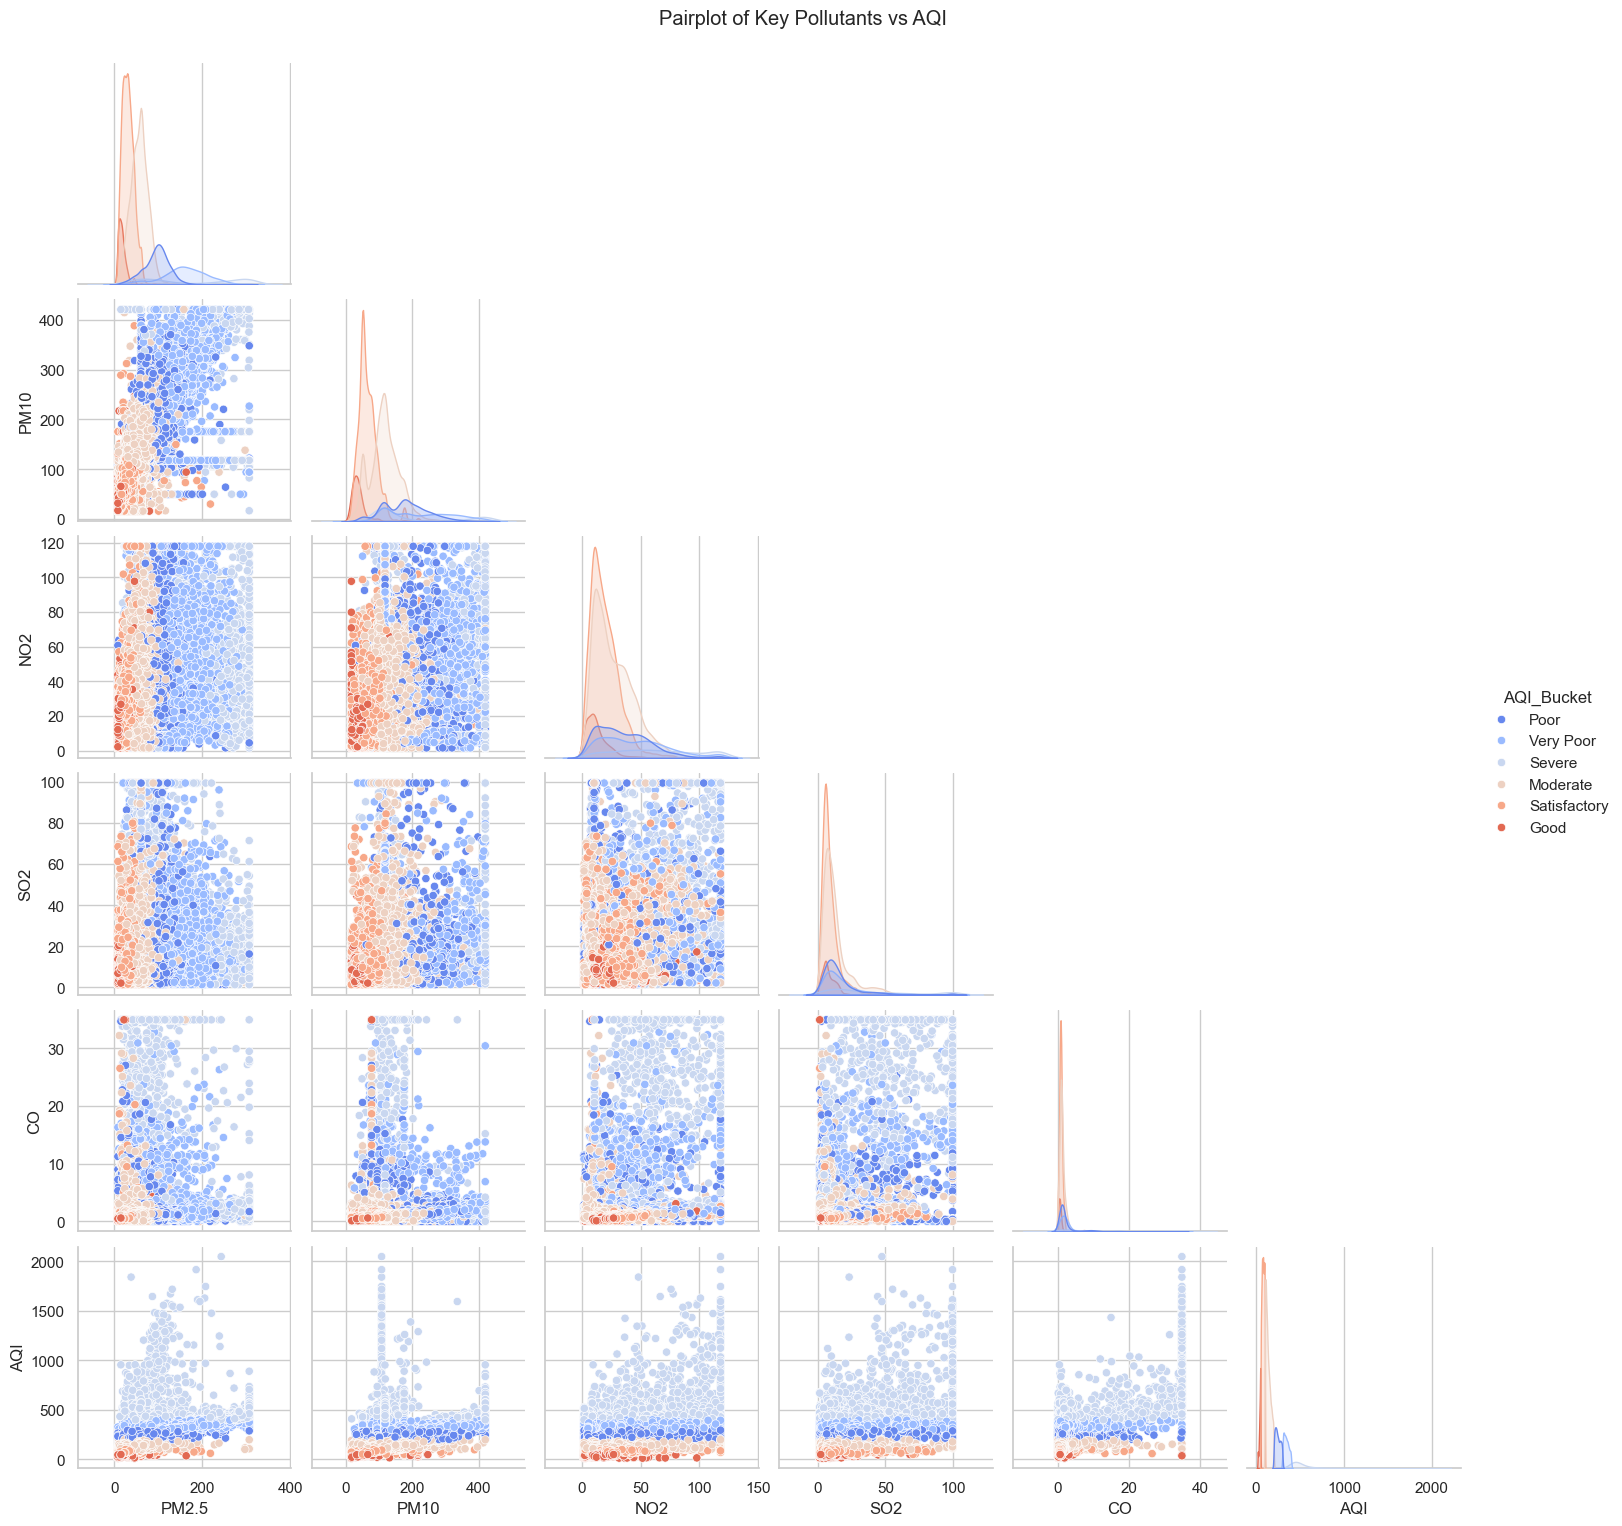

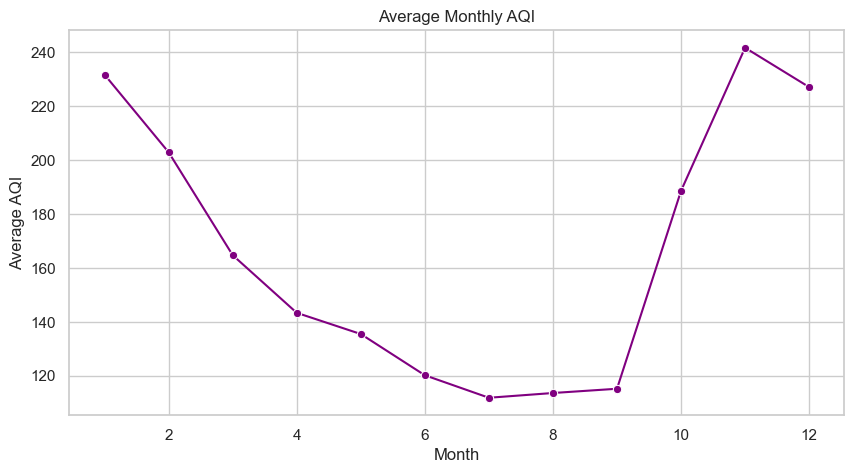

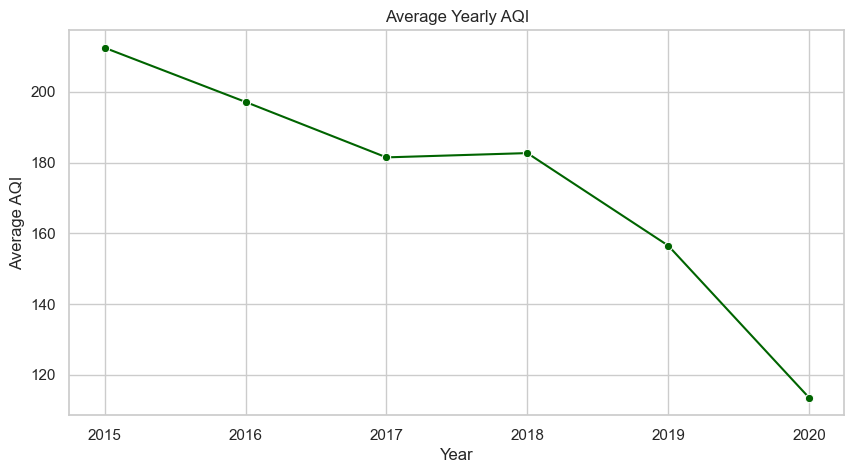

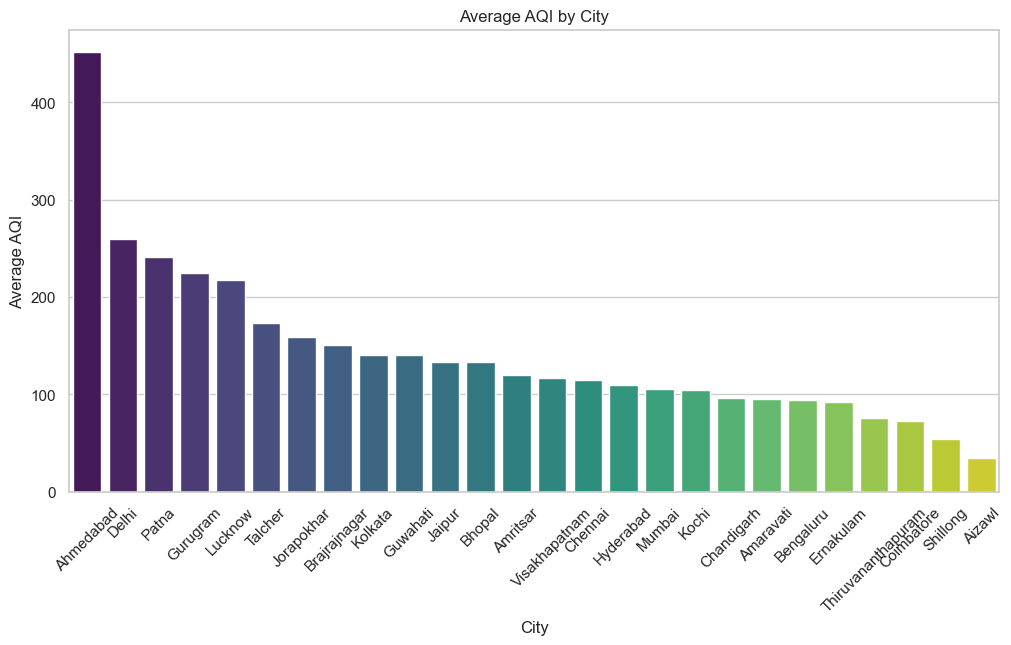

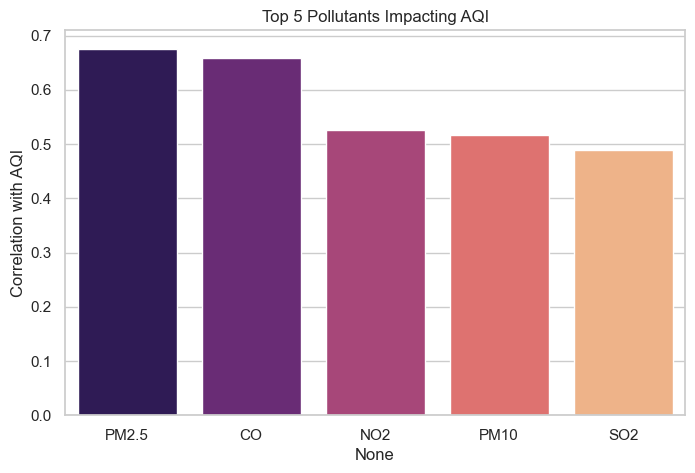

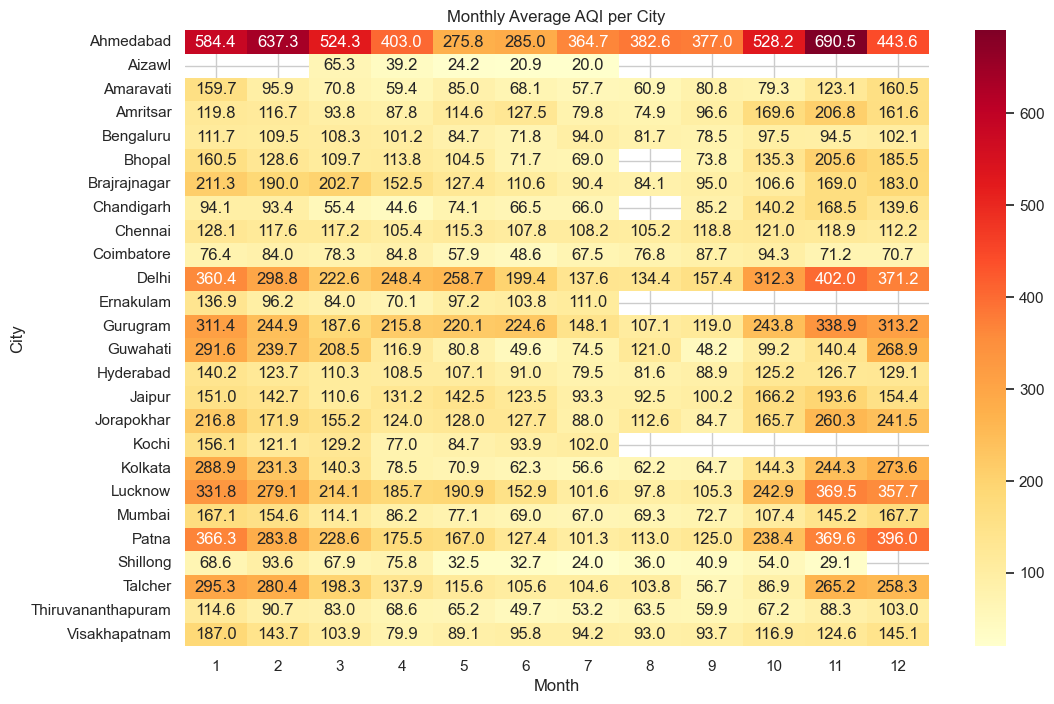

In [5]:
# Comprehensive EDA of the dataset

# --- 1. Check if 'AQI_Bucket' exists ---
if 'AQI_Bucket' not in df.columns:
    print("Warning: 'AQI_Bucket' column not found. Skipping categorical AQI analysis.")
else:
    # Drop rows with missing AQI_Bucket for plotting
    df_eda = df.dropna(subset=['AQI_Bucket'])
    
    # AQI Bucket Distribution
    plt.figure(figsize=(8,5))
    sns.countplot(data=df_eda, x='AQI_Bucket', order=df_eda['AQI_Bucket'].value_counts().index, palette='Spectral')
    plt.title("Distribution of AQI Buckets")
    plt.xlabel("AQI Category")
    plt.ylabel("Count")
    plt.show()

# --- 2. Pollutant Distributions ---
pollutant_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
df[pollutant_cols].hist(bins=30, figsize=(16,12), color='lightgreen', edgecolor='black')
plt.suptitle("Distributions of Pollutants", fontsize=16)
plt.show()

# --- 3. Boxplots for Outlier Detection ---
plt.figure(figsize=(16,12))
for i, col in enumerate(pollutant_cols):
    plt.subplot(4,3,i+1)
    sns.boxplot(df[col], color='lightblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# --- 4. Correlation Heatmap ---
plt.figure(figsize=(12,10))
corr_matrix = df[pollutant_cols + ['AQI']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Between Pollutants and AQI")
plt.show()

# --- 5. Pairplot for Key Pollutants (safe) ---
key_cols = ['PM2.5','PM10','NO2','SO2','CO','AQI']
if 'AQI_Bucket' in df_eda.columns:
    sns.pairplot(df_eda[key_cols + ['AQI_Bucket']], hue='AQI_Bucket', palette='coolwarm', corner=True)
    plt.suptitle("Pairplot of Key Pollutants vs AQI", y=1.02)
    plt.show()
else:
    sns.pairplot(df[key_cols], corner=True)
    plt.suptitle("Pairplot of Key Pollutants vs AQI", y=1.02)
    plt.show()

# --- 6. Temporal Analysis ---
# Average AQI per month
monthly_aqi = df.groupby('Month')['AQI'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_aqi, x='Month', y='AQI', marker='o', color='purple')
plt.title("Average Monthly AQI")
plt.xlabel("Month")
plt.ylabel("Average AQI")
plt.show()

# Average AQI per year
yearly_aqi = df.groupby('Year')['AQI'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=yearly_aqi, x='Year', y='AQI', marker='o', color='darkgreen')
plt.title("Average Yearly AQI")
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.show()

# --- 7. City-wise AQI Comparison ---
plt.figure(figsize=(12,6))
city_aqi = df.groupby('City')['AQI'].mean().sort_values(ascending=False)
sns.barplot(x=city_aqi.index, y=city_aqi.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Average AQI by City")
plt.xlabel("City")
plt.ylabel("Average AQI")
plt.show()

# --- 8. Top Pollutants Impacting AQI ---
top_corr_pollutants = corr_matrix['AQI'].abs().sort_values(ascending=False)[1:6]
plt.figure(figsize=(8,5))
sns.barplot(x=top_corr_pollutants.index, y=top_corr_pollutants.values, palette='magma')
plt.title("Top 5 Pollutants Impacting AQI")
plt.ylabel("Correlation with AQI")
plt.show()

# --- 9. Heatmap: Monthly AQI per City ---
monthly_city_aqi = df.groupby(['City','Month'])['AQI'].mean().unstack()
plt.figure(figsize=(12,8))
sns.heatmap(monthly_city_aqi, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title("Monthly Average AQI per City")
plt.xlabel("Month")
plt.ylabel("City")
plt.show()


In [6]:
# Feature Encoding, Scaling, and Train-Test Split

# --- 1. Define Features and Target ---
# Drop columns that won't be used for modeling
drop_cols = ['Date', 'AQI_Bucket', 'AQI']  # AQI is numeric target, AQI_Bucket categorical
X = df.drop(columns=drop_cols)
y = df['AQI_Bucket']  # Target: AQI category

# --- 2. Identify Categorical and Numerical Columns ---
categorical_cols = ['City']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# --- 3. Preprocessing Pipeline ---
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# --- 4. Train-Test Split ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5. Apply Preprocessing ---
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train distribution:\n{y_train.value_counts()}")
print(f"y_test distribution:\n{y_test.value_counts()}")


X_train shape: (19880, 43)
X_test shape: (4970, 43)
y_train distribution:
AQI_Bucket
Moderate        7063
Satisfactory    6579
Poor            2225
Very Poor       1870
Good            1073
Severe          1070
Name: count, dtype: int64
y_test distribution:
AQI_Bucket
Moderate        1766
Satisfactory    1645
Poor             556
Very Poor        467
Good             268
Severe           268
Name: count, dtype: int64


Classification Report:

              precision    recall  f1-score   support

        Good       0.74      0.76      0.75       268
    Moderate       0.83      0.83      0.83      1766
        Poor       0.71      0.71      0.71       556
Satisfactory       0.84      0.84      0.84      1645
      Severe       0.86      0.81      0.83       268
   Very Poor       0.78      0.80      0.79       467

    accuracy                           0.81      4970
   macro avg       0.79      0.79      0.79      4970
weighted avg       0.81      0.81      0.81      4970



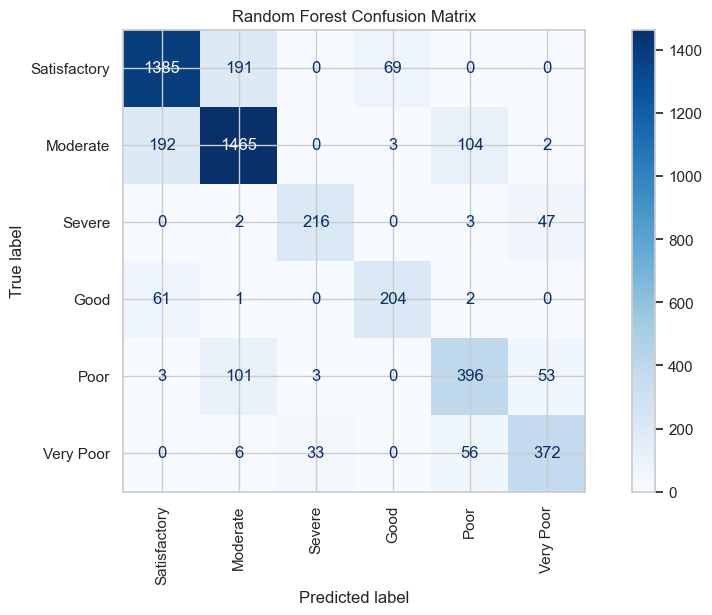

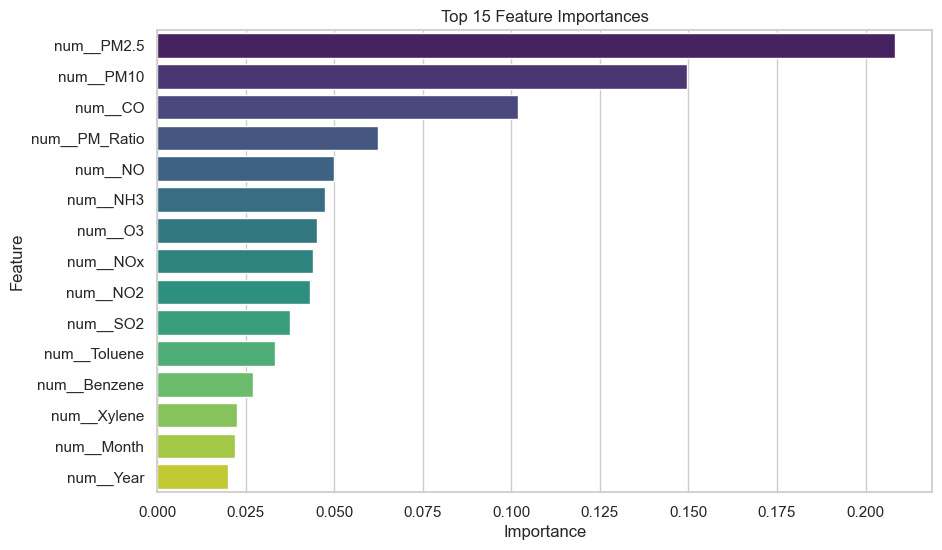

In [7]:
# Baseline Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Initialize the Model ---
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)

# --- 2. Train the Model ---
rf_model.fit(X_train_scaled, y_train)

# --- 3. Predictions ---
y_pred = rf_model.predict(X_test_scaled)

# --- 4. Evaluation ---
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Random Forest Confusion Matrix")
plt.show()

# --- 5. Feature Importance ---
importances = rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title("Top 15 Feature Importances")
plt.show()


LightGBM Classification Report:

              precision    recall  f1-score   support

        Good       0.72      0.78      0.75       268
    Moderate       0.84      0.83      0.84      1766
        Poor       0.69      0.74      0.71       556
Satisfactory       0.85      0.84      0.85      1645
      Severe       0.83      0.84      0.83       268
   Very Poor       0.79      0.77      0.78       467

    accuracy                           0.82      4970
   macro avg       0.79      0.80      0.79      4970
weighted avg       0.82      0.82      0.82      4970



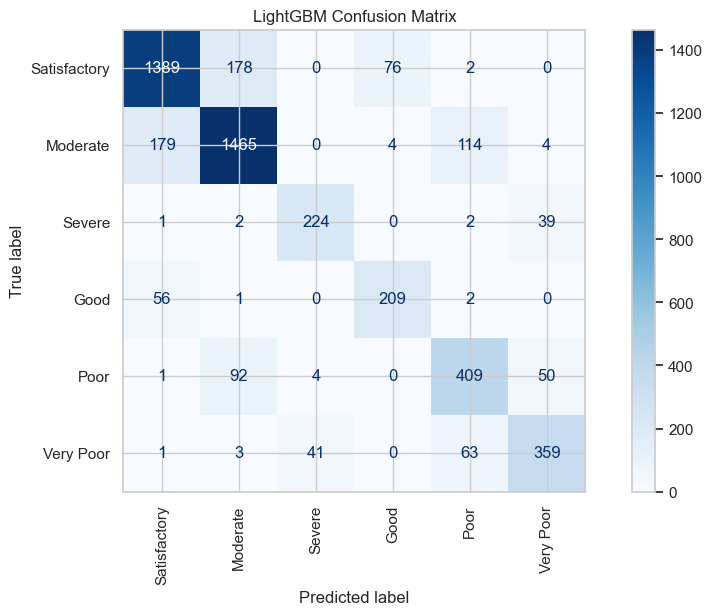

SHAP Summary Plot for Class: Satisfactory
SHAP Summary Plot for Class: Moderate
SHAP Summary Plot for Class: Severe
SHAP Summary Plot for Class: Good
SHAP Summary Plot for Class: Poor
SHAP Summary Plot for Class: Very Poor


In [8]:
# LightGBM Model with SHAP for model interpretability

import lightgbm as lgb
import shap

# --- 1. Initialize LightGBM Classifier ---
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=12,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    verbose=-1  # suppress info messages
)

# --- 2. Train the Model ---
lgb_model.fit(X_train_scaled, y_train)

# --- 3. Predictions ---
y_pred_lgb = lgb_model.predict(X_test_scaled)

# --- 4. Evaluation ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("LightGBM Classification Report:\n")
print(classification_report(y_test, y_pred_lgb))

# Confusion Matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb, labels=y_test.unique())
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=y_test.unique())
disp_lgb.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("LightGBM Confusion Matrix")
plt.show()

# --- 5. SHAP Explainability ---
# Initialize SHAP explainer
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_scaled)

# For multiclass, shap_values is a list (one array per class)
feature_names = preprocessor.get_feature_names_out()

for i, class_name in enumerate(y_test.unique()):
    print(f"SHAP Summary Plot for Class: {class_name}")
    
    # Ensure the SHAP values array has correct shape
    shap_values_class = shap_values[i]  # array of shape (n_samples, n_features)
    if shap_values_class.shape[1] == X_test_scaled.shape[1]:
        shap.summary_plot(shap_values_class, X_test_scaled, feature_names=feature_names, plot_type='bar', show=True)
    else:
        print(f"Warning: SHAP values for class {class_name} do not match feature shape. Skipping this class.")


In [9]:
import joblib

# Save trained LightGBM model
joblib.dump(lgb_model, "lightgbm_aqi_model.pkl")
print("Model saved as lightgbm_aqi_model.pkl")


Model saved as lightgbm_aqi_model.pkl


#  Project Documentation: Air Quality Index (AQI) Prediction

## 🔹 Project Overview
This project aims to develop a **machine learning model** that predicts the **Air Quality Index (AQI) category** based on environmental pollutant levels. The solution leverages data preprocessing, exploratory data analysis (EDA), model training, evaluation, and interpretability methods.

---

## 🔹 Workflow Summary

1. **Environment Setup**
   - Installed and imported required libraries (`pandas`, `numpy`, `matplotlib`, `scikit-learn`, `lightgbm`, `shap`, etc.).

2. **Data Loading & Cleaning**
   - Loaded dataset containing pollutant concentrations and AQI categories.
   - Handled missing values and ensured correct data types.

3. **Exploratory Data Analysis (EDA)**
   - Explored distributions of pollutants.
   - Checked correlations between pollutants and AQI categories.
   - Visualized AQI class distribution to identify imbalances.

4. **Data Preprocessing**
   - Scaled numerical features with `StandardScaler`.
   - Encoded categorical features with `OneHotEncoder`.
   - Split dataset into **training (80%)** and **testing (20%)** sets.

5. **Model Training**
   - Trained multiple classifiers:
     - **Random Forest Classifier**
     - **LightGBM Classifier (final model)**
   - Used **class weights** to handle imbalanced AQI classes.

6. **Model Evaluation**
   - Evaluated performance using:
     - Accuracy
     - Precision, Recall, and F1-score (per class)
     - Confusion Matrix
   - Final **LightGBM Model** achieved:
     - **Accuracy ≈ 82%**
     - Balanced performance across AQI categories

7. **Explainability with SHAP**
   - Used **SHAP (SHapley Additive exPlanations)** to interpret model predictions.
   - Generated feature importance plots for each AQI category.

8. **Model Saving**
   - Final LightGBM model saved as:
     - `lightgbm_aqi_model.pkl` (only model)
   - Optionally, the **preprocessing pipeline** can also be saved with the model for end-to-end deployment.

---

##  Key Insights
- **PM2.5, PM10, and NO₂** were among the strongest predictors of AQI categories.
- LightGBM provided a **better balance of precision and recall** compared to Random Forest.
- SHAP values offered valuable interpretability for stakeholders.

---

##  Next Steps
- Deploy the model via a **Flask/Django API** or a **Streamlit dashboard**.
- Integrate real-time air quality sensor data for live predictions.
- Continuously retrain and improve model with new data.

---

##  Final Deliverables
- **Trained LightGBM Model:** `lightgbm_aqi_model.pkl`
- **Jupyter Notebook:** Complete step-by-step workflow
- **Documentation:** This report

---
